In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from einops import rearrange
from PIL import Image
from tqdm import tqdm
import json
import time
from pathlib import Path
from sklearn import linear_model
import mediapy as media

In [9]:
!ls -lt baselines

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
def load_run_data(run_path):
    run_lists = []
    for p in Path(run_path).glob('all_runs_*.json'):
        with open(p, 'r') as f:
            run_lists.append(json.load(f))
    all_runs = [val for tup in zip(*run_lists) for val in tup]
    print(f'runs loaded: {len(all_runs)}')
    return all_runs

In [11]:
def plot_runs(
    all_runs, use_keys=None, 
    plot_fit=False, plot_line=False, 
    start=0, group_runs=1,
    agg_func=np.mean):
    
    all_runs = all_runs[start:]
    x = np.arange(len(all_runs)//group_runs)
    
    def add_plot(y, name, alpha, size, plot_line, plot_fit):
        plt.scatter(x, y, alpha=alpha, s=size, label=name)
        if plot_line:
            plt.plot(x, y, alpha=alpha, label=name)
        if plot_fit:
            regr = linear_model.LinearRegression()
            # Optimize linear model
            regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))

            # Make predictions using the testing set
            lin_y = regr.predict(x.reshape(-1, 1))
            plt.plot(x, lin_y, linewidth=3)
    
    # convert list of dictionaries to dictionary of lists
    metrics = {m: [run[m] for run in all_runs] for m in all_runs[0].keys()}
    metrics['total'] = [sum([v for _,v in run.items()]) for run in all_runs]
    if group_runs:
        for m, dat in metrics.items():
            metrics[m] = agg_func(np.array(dat).reshape(-1, group_runs), 1)
    available_keys = metrics.keys()
    print(f'available metrics: {list(available_keys)}')
    if use_keys is None:
        use_keys = available_keys
    
    ## TODO subplot for each metric ## 
    NUM_COLORS = len(use_keys)
    cm = plt.get_cmap('Dark2')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize = (12, 8))

    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])

    for i, m in enumerate(use_keys):
        add_plot(
            np.array(metrics[m]), m, 1.0, 3.0, plot_line, plot_fit
        )

    plt.title('Reward over runs PPO')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()

In [12]:
def get_latest_grid(pth):
    imgs = np.array([np.array(Image.open(p)) for p in Path(pth).glob('curframe*.jpeg')])
    grid = rearrange(imgs, '(h2 w2) h w c -> (h2 h) (w2 w) c', w2=4)
    return grid

In [13]:
'''
get_im_func = lambda: get_latest_grid('baselines/session_d34118d3')

with media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:
    for i in range(500):
        #wr.add_image(get_im_func())
        #time.sleep(1)
'''        

"\nget_im_func = lambda: get_latest_grid('baselines/session_d34118d3')\n\nwith media.VideoWriter('test_grid.mp4', get_im_func().shape[:2]) as wr:\n    for i in range(500):\n        #wr.add_image(get_im_func())\n        #time.sleep(1)\n"

In [14]:
grid = get_latest_grid('baselines/session/session_4da05e87')
if len(grid.shape) == 3:
    grid = np.expand_dims(grid, axis=0)
plt.imshow(rearrange(grid, '(h2 w2) h w c -> (h2 h) (w2 w) c', w2=4))


EinopsError:  Error while processing rearrange-reduction pattern "(h2 w2) h w c -> (h2 h) (w2 w) c".
 Input tensor shape: (0,). Additional info: {'w2': 4}.
 Expected 4 dimensions, got 1

In [ ]:
(29556736 - 25952256) / (1024*16*44)

5.0

runs loaded: 26840
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


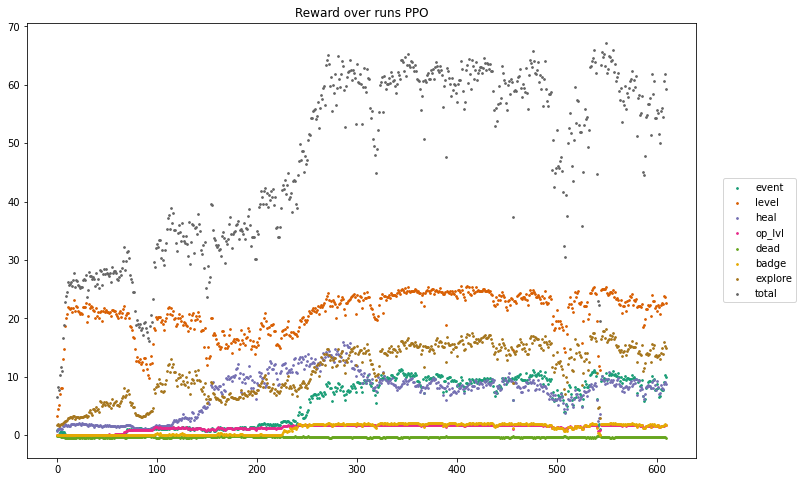

In [ ]:
plot_runs(
    load_run_data('baselines/session_4da05e87_main_full'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=44*0,
    group_runs=44,
    agg_func=np.mean
)

runs loaded: 15312
available metrics: ['event', 'level', 'heal', 'op_lvl', 'dead', 'badge', 'explore', 'total']


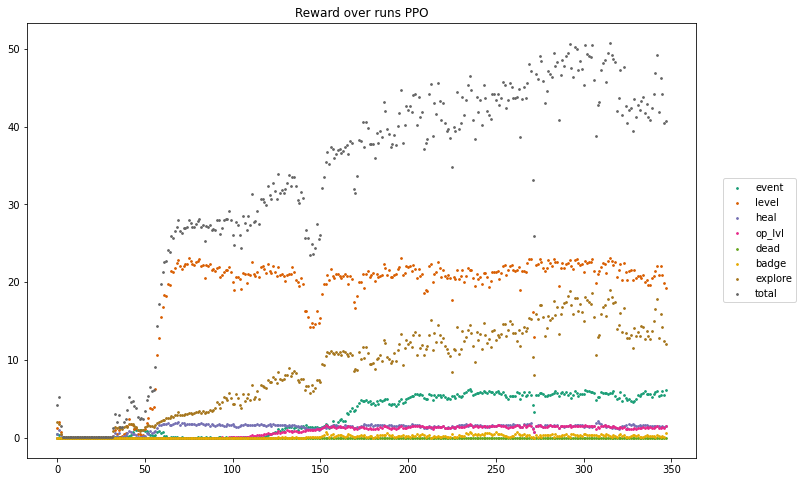

In [ ]:
plot_runs(
    load_run_data('baselines/session_e41c9eff'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=44,
    agg_func=np.mean
)

In [ ]:
plot_runs(
    load_run_data('baselines/session_812437f3_3k_explore'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)

runs loaded: 0


IndexError: list index out of range

runs loaded: 4608
available metrics: ['levels', 'explore', 'total']


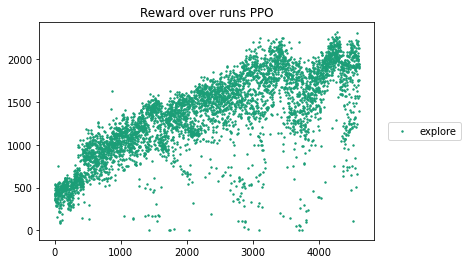

In [ ]:

plot_runs(
    load_run_data('baselines/session_82b536f8_makes_it_to_gym'),
    use_keys=['explore'],
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


runs loaded: 6336
available metrics: ['levels', 'explore', 'total']


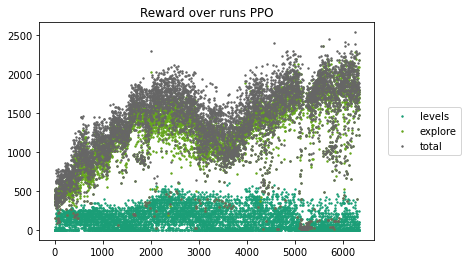

In [ ]:

plot_runs(
    load_run_data('baselines/session_bad50734'),
    use_keys=None,
    plot_line=False,
    plot_fit=False,
    start=0,
    group_runs=1,
    agg_func=np.mean
)


## generate moving histograms!

In [ ]:
len(load_run_data('baselines/session_4da05e87_main_full'))

runs loaded: 26840


26840

In [ ]:
def chunks(data, n):
    n = max(1, n)
    return [data[i:i+n] for i in range(0, len(data), n)]

In [ ]:
full_dat = load_run_data('baselines/session_4da05e87_main_full')
for run in full_dat:
    run["total"] = sum(value for value in run.values())
full_dat_chunks = chunks(full_dat, 44)

runs loaded: 26840


In [ ]:
full_dat[0]

{'event': 0,
 'level': 2,
 'heal': 0.7431809773652174,
 'op_lvl': 0.0,
 'dead': -0.30000000000000004,
 'badge': 0,
 'explore': 1.488,
 'total': 3.931180977365217}

In [ ]:
def histo_plot(axis, stat, dat_chunks, version, compare_count):
    
    test_dat = np.array([run[stat] for run in dat_chunks[version]])
    # the histogram of the data
    n, bins, patches = axis.hist(test_dat, 10, density=False, facecolor="orange", alpha=0.95)
    
    for i in range(compare_count):
        comp_version = max(version - 1 - i, 0)
        compare_dat = np.array([run[stat] for run in dat_chunks[comp_version]])
        n, bins, patches = axis.hist(compare_dat, 10, density=False, facecolor="grey", alpha=0.2*0.25**i)

    axis.set(xlabel=f"{stat}")
    #axis.ylabel()
    # only use this title over all plots
    #axis.title()
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)
    #axis.grid(True)
    #plt.show()

In [ ]:
def plot_all(dat_chunks, version, compare_count):
    fig, axs = plt.subplots(2, 4, figsize=(16, 9), dpi=120)
    #plt.subplots_adjust(bottom=0.0, right=0.8, top=0.9)
    fig.suptitle(f"Version {version} Rewards")
    for stat, ax in zip(dat_chunks[0][0].keys(), axs.flatten()):
        histo_plot(ax, stat, dat_chunks, version, compare_count)
    return fig


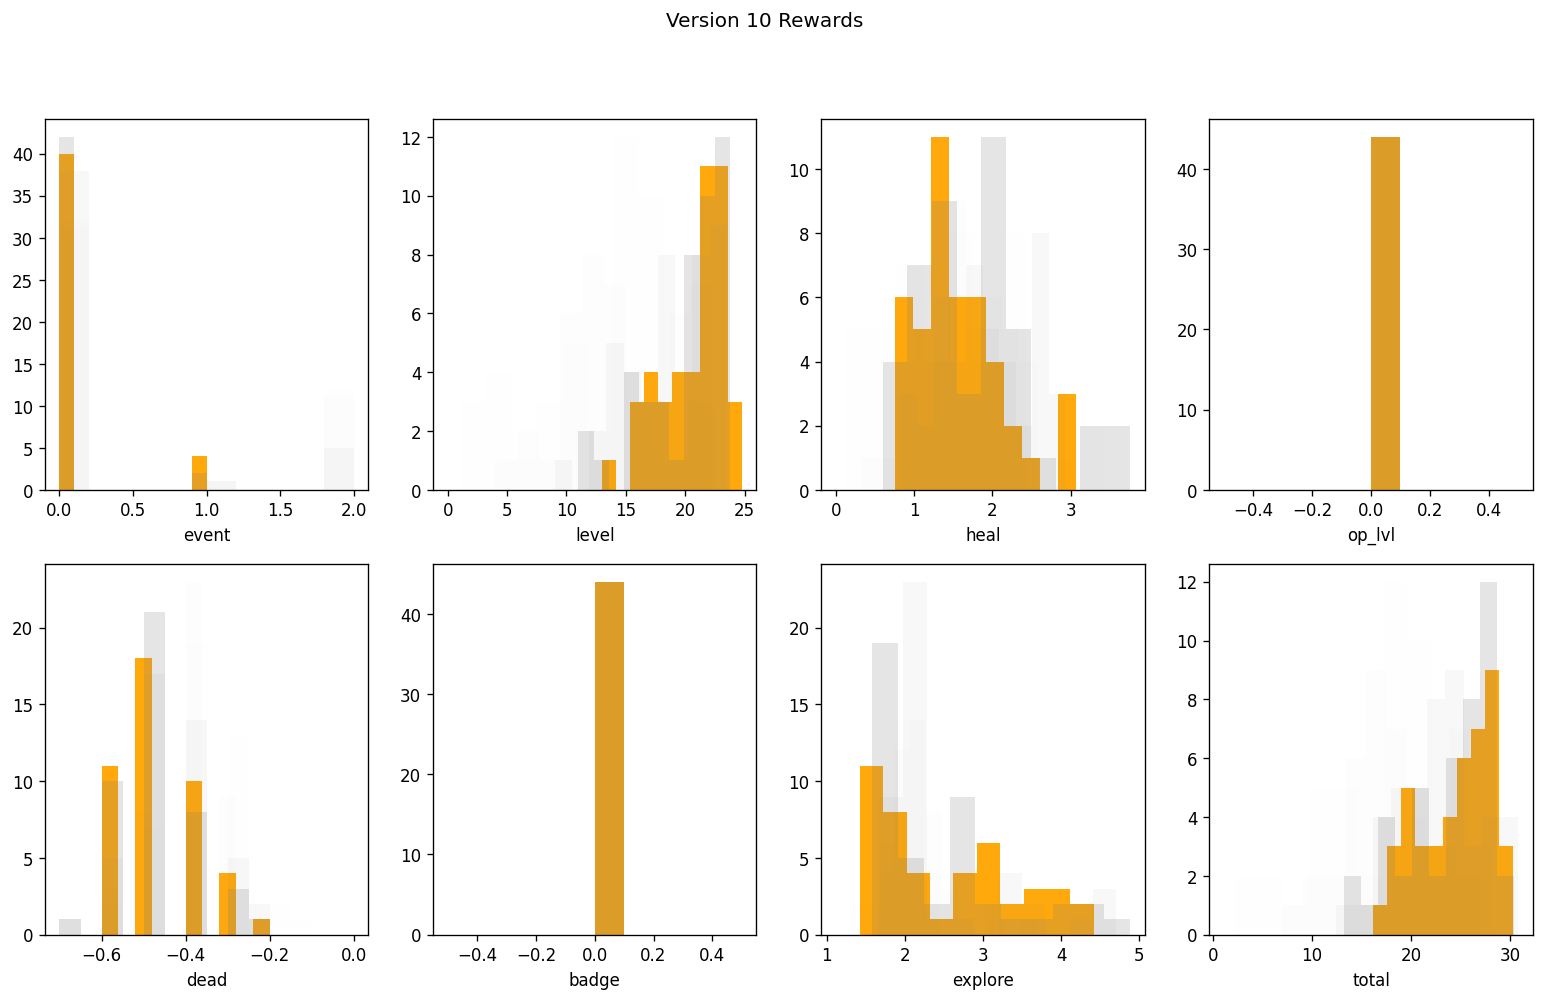

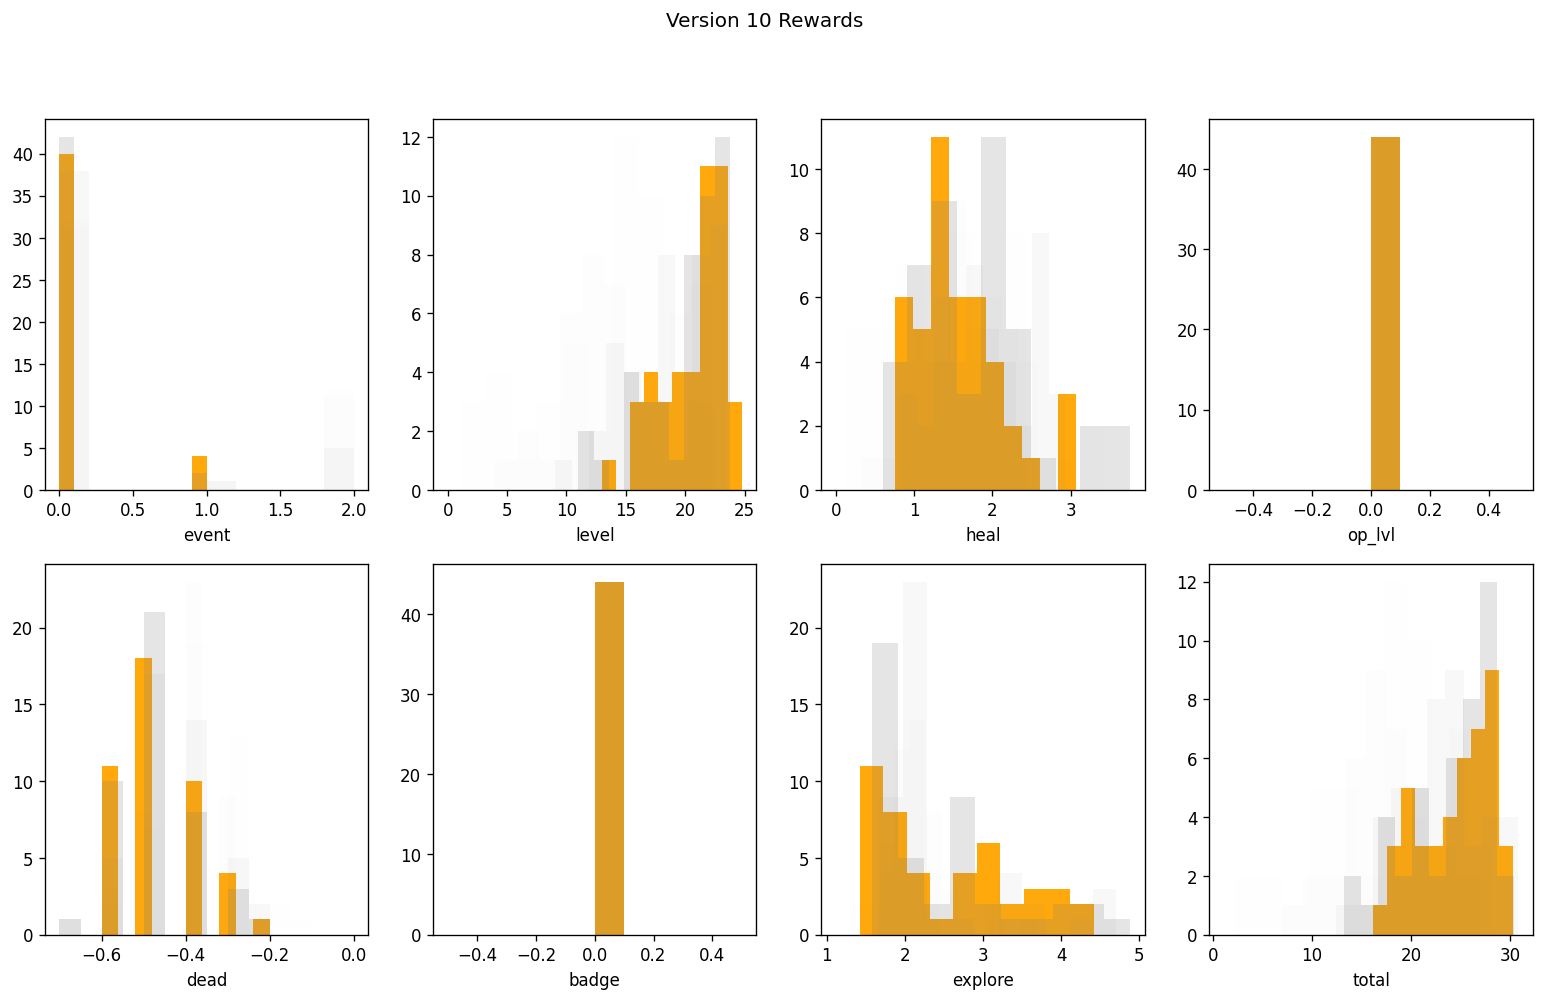

In [ ]:
plot_all(chunks(full_dat, 44), 10, 5)

In [ ]:
#histo_plot("level", )

In [ ]:
with media.VideoWriter('histograms_over_time.mp4', (1080, 1920)) as wr:
    for i in tqdm(range(610)):
        #with plt.style.context('Solarize_Light2'):
        fig = plot_all(full_dat_chunks, i, 5)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()

TypeError: 'module' object is not callable